# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [3]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [6]:
data = pd.read_excel('C:/Users/文思琪/Downloads/spy_data.xlsx', sheet_name=1).set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPY'] - data['^IRX'] 
rets = data['excess_returns']
data.tail()

,SPY,^IRX,excess_returns
date,,,
2024-07-29,0.000588,0.000204,0.000384
2024-07-30,-0.005066,0.000204,-0.005270
2024-07-31,0.016255,0.000204,0.016051
2024-08-01,-0.014161,0.000203,-0.014364
2024-08-02,-0.018618,0.000200,-0.018818


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Index(['SPY', '^IRX', 'excess_returns'], dtype='object')


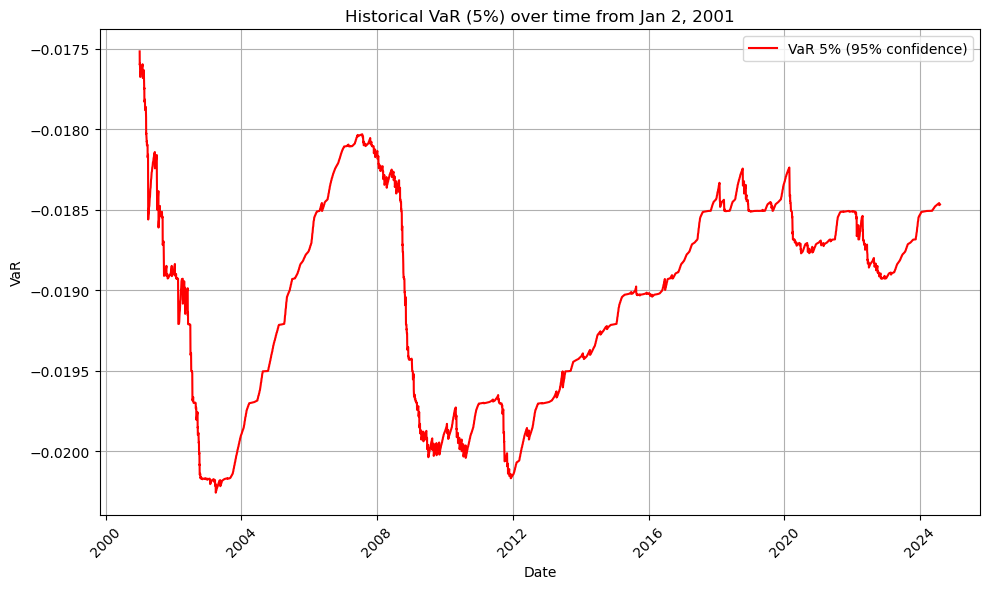

Frequency of periods where actual returns < VaR: 0.0488
Compare this to 5% quantile (0.05)


In [13]:
#1.Var over time and plot var
print(data.columns)

# filter datas
data_filtered = data[data.index <= '2000-12-29']

# 5% quantile for 95% confidence level
def calculate_historical_var(returns, alpha=0.05):
    return np.percentile(returns, 100 * alpha)

var_values = []

# expand calculate window from starting date
start_date = '2001-01-02'
for i in range(len(data_filtered), len(data)):
    expanding_window_data = data['SPY'].iloc[:i]
    var_t = calculate_historical_var(expanding_window_data, alpha=0.05)
    var_values.append(var_t)

# extract date from starting date
dates_for_var = data.index[len(data_filtered):]

plt.figure(figsize=(10, 6))
plt.plot(dates_for_var, var_values, label="VaR 5% (95% confidence)", color='red')
plt.title('Historical VaR (5%) over time from Jan 2, 2001')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#2.compare actual r with var r
count_below_var = sum(data['SPY'].iloc[len(data_filtered):] < var_values)
total_periods = len(var_values)
frequency = count_below_var / total_periods

print(f"Frequency of periods where actual returns < VaR: {frequency:.4f}")
print(f"Compare this to 5% quantile (0.05)")

nearly the same, with a nuance that actual return has a smaller possibility of loss than VAR, which shows that our portfoli has a great performance.

#drawbacks
1.heavily depending on history data, the availability of data is a problem.
2.Equal Weights issue: Equal Weights between past observations and recent observations may cause estimate error. For example, low returns during 2008 (which may not be relevant anymore) are given the same weight as the most recent observations，but recent return like the t-1 return, which should have more impact on t, is also gave the equal weight.s.).

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

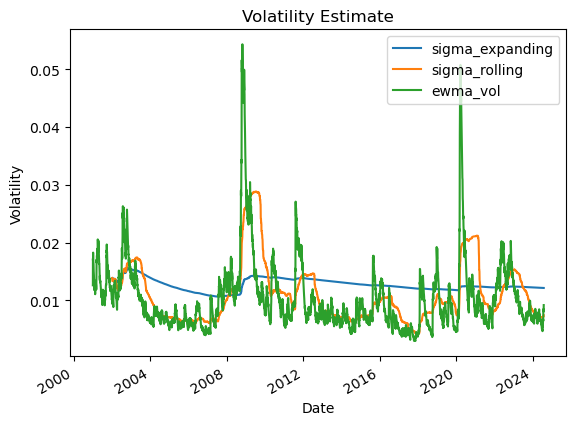

In [19]:
#1
#filter data
rets.index = pd.to_datetime(rets.index)
start_date = '2001-01-02'
rets_filtered = rets.loc[start_date:]
METHODS = ['expanding vol','rolling vol','ewma_vol']
#calculate expanding vol
WINDOW = 252
sigma_expanding = rets_filtered.expanding(WINDOW).std()
#calculate rolling vol
sigma_rolling = rets_filtered.rolling(WINDOW).std()
#calculate EWMA
theta = 0.94 
initial_vol = 0.20 / np.sqrt(252) 
#initialization
ewma_vol_squared = np.zeros(len(rets_filtered))
ewma_vol_squared[0] = initial_vol**2

#recursive computation
for t in range(1, len(rets_filtered)):
    ewma_vol_squared[t] = theta * ewma_vol_squared[t-1] + (1 - theta) * rets_filtered[t-1]**2
ewma_vol = np.sqrt(ewma_vol_squared)
#plot
std = pd.DataFrame({'sigma_expanding': sigma_expanding, 'sigma_rolling': sigma_rolling,'ewma_vol':ewma_vol})
std.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
plt.show()


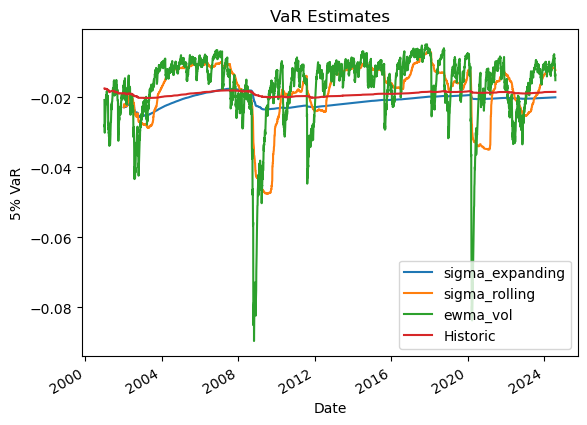

In [25]:
#2
VaR = -1.65 * std
VaR['Historic'] = var_values

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')
plt.show()

In [27]:
#3
historic_VaR = pd.Series(var_values, index=rets_filtered.index)
z_95 = -1.645 

VaR_expanding = sigma_expanding * z_95
VaR_rolling = sigma_rolling * z_95
VaR_EWMA = ewma_vol * z_95

count_expanding = np.sum(rets_filtered < VaR_expanding)
count_rolling = np.sum(rets_filtered < VaR_rolling)
count_EWMA = np.sum(rets_filtered < VaR_EWMA)
count_historic = np.sum(rets_filtered < historic_VaR)


total_periods = len(rets_filtered)


frequency_expanding = count_expanding / total_periods
frequency_rolling = count_rolling / total_periods
frequency_EWMA = count_EWMA / total_periods
frequency_historic = count_historic / total_periods
print(f"Frequency for Expanding VaR: {frequency_expanding:.2%}")
print(f"Frequency for Rolling VaR: {frequency_rolling:.2%}")
print(f"Frequency for EWMA VaR: {frequency_EWMA:.2%}")
print(f"Frequency for Historic VaR: {frequency_historic:.2%}")

Frequency for Expanding VaR: 3.54%
Frequency for Rolling VaR: 5.06%
Frequency for EWMA VaR: 6.04%
Frequency for Historic VaR: 4.89%


Rolling window is a much accurate estimate because it only counts on the most recent observations.???

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

<Axes: title={'center': 'CVaR estimates'}, xlabel='Date', ylabel='5% CVaR'>

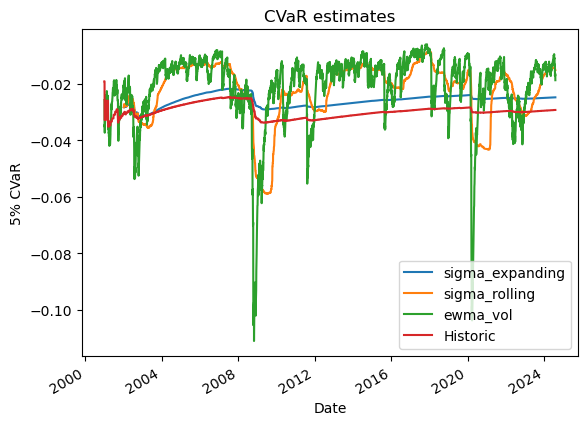

In [32]:
#1 Historic CVaR
CVaR = -norm.pdf(1.65) / 0.05 * std
CVaR['Historic'] = rets.loc['2000-12-29':].expanding().apply(lambda x: x[x < x.quantile(.05)].mean())
CVaR.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')



***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.